In [1]:
FEATURES_DIM = 10

In [2]:
import numpy as np
from ensmallen.datasets.linqs import Cora
from ensmallen.datasets.linqs.parse_linqs import get_words_data
cora = Cora()
features = get_words_data(cora)
cora = cora.filter_from_names(node_type_name_to_filter=["Word"])
cora = cora.remove_edge_weights()
features = features.loc[cora.get_node_names()]

Extracting words features:   0%|          | 0/4141 [00:00<?, ?it/s]

In [3]:
cora

The undirected graph Cora has 2708 nodes and 5278 unweighted edges, of which none are self-loops. The graph is sparse as it has a density of 0.00144 and has 78 connected components, where the component with most nodes has 2485 nodes and the component with the least nodes has 2 nodes. The graph median node degree is 3, the mean node degree is 3.90, and the node degree mode is 2. The top 5 most central nodes are 35 (degree 168), 6213 (degree 78), 1365 (degree 74), 3229 (degree 65) and 910 (degree 44). The hash of the graph is a41efb907f4ed0f0.

In [90]:
from multiprocessing.sharedctypes import Value
from scipy import sparse as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from ensmallen import Graph

def build_layer_random_matrix(n_rows, n_cols, n_elements_not_zero_per_row, scaling):
    if n_cols < n_elements_not_zero_per_row:
        raise ValueError("n_elements_not_zero_per_row must be bigger than the number of columns")
    
    A = np.zeros((n_rows, n_cols))
    
    for i in range(n_rows):
        positions = np.random.choice(np.arange(n_cols), size=n_elements_not_zero_per_row, replace=False)
        A[i, positions] = scaling * np.random.uniform(-1, 1, n_elements_not_zero_per_row)
    return A


class FDGNN:
    def __init__(self,
        features_number: int,
        max_node_degree: float,
        embedding_size: int = 10,
        filters: int = 5,
        maximum_spectral_radius: float = 0.9,
        kernel_size: int = 1,
        input_scaling: float = 1.0,
        inter_scaling: float = 1.0,
        number_of_hidden_layers: int = 1,
        convergence_threshold: float = 1e-9,
        max_iterations: int = 50,
    ):
        """
        Fast and Deep Graph Neural Newtorks by 

        In this model the hyperparameters tuned by the authors are:
            rho
            input_scaling
            inter_scaling
            embedding_size
            number_of_hidden_layers

        Parameters
        ----------
        features_number: int,
            Expected number of input features, equivalent to U in the paper.
        max_node_degree: float,
            The maximum node degree of the graph to embed, in the paper it seems to refer to the maximum while in the matlab implementation made available alongside the paper it seems to be expecting the mean node degree.
        embedding_size: int = 10
            Dimension of the embedding matrix. By default this is supposed to be twice the number of filters.
        filters: int = 5,
            Dimension of units in each hidden layer.
        maximum_spectral_radius: float = 0.9,
            Value to normalize the spectral radius of the matrix to.
            The lower the value is, the faster the convergence will be.
        kernel_size: int = 1,
            TODO!, which is equivalent to the number of non zero values in each row of the Wi and Wh matrices.
        input_scaling: float = 1.0
            Scale the Wi matrix by this hyperparameter
        inter_scaling: float = 1.0
            Scale the Wi matrix by this hyperparameter
        number_of_hidden_layers: int = 1,
            How many iterations of the FDGNN algorithm 
        convergence_threshold: 1e-3,
            The minimum difference that an iteration must produce on all the nodes embeddings
            before early stopping.
        max_iterations: int = 50,
            The maximum number of iterations before early stopping for each layer.
        Raises
        -------
        ValueError
            If the maximum spectral value is not within 0 and 1.
        """
        if maximum_spectral_radius >= 1.0 or maximum_spectral_radius <= 0.0:
            raise ValueError("The maximum spectral radius must be a real value strictly between 0 and 1.")

        # network parameters
        self._embedding_size = embedding_size
        self._filters = filters
        self._number_of_hidden_layers = number_of_hidden_layers
        self._kernel_size = kernel_size

        # early stopping
        self._convergence_threshold = convergence_threshold
        self._max_iterations = max_iterations

        # shapes info
        self._features_number = features_number
        self._max_node_degree = max_node_degree

        # Scalar Hyperparameters
        self._maximum_spectral_radius = maximum_spectral_radius
        self._input_scaling = input_scaling
        self._inter_scaling = inter_scaling

        # Input and Neighbours matrices, one for each layer
        self.Wi = [None] * self._number_of_hidden_layers
        self.Wh = [None] * self._number_of_hidden_layers

        # initialization of input weight matrix for the first layer
        self.Wi[0] = build_layer_random_matrix(
            self._filters, self._features_number + 1, self._kernel_size, self._input_scaling)

        # initialization of the input weight matrix for successive layers
        for i in range(1, self._number_of_hidden_layers):
            # initialization of the i-th inter-layer weight matrix
            self.Wi[i] = build_layer_random_matrix(
                self._filters, self._filters + 1, self._kernel_size, self._inter_scaling)

        # initialize the recurrent weight matrices for the hidden layers
        for i in range(self._number_of_hidden_layers):
            # initialization of the i-th recurrent weight matrix
            self.Wh[i] = build_layer_random_matrix(self._filters, self._filters, self._kernel_size, 1)

            # rescaling based on GES necessary condition (Theorem 2)
            self.Wh[i] = self._maximum_spectral_radius * self.Wh[i] / \
                np.abs(np.linalg.eigvals(self.Wh[i])).max() / self._max_node_degree

        # initialization of the projection matrix
        # the projection matrix is randomly initialized and then it is
        # kept under control by re-scaling its highest singular value
        self.Wphi = np.random.uniform(-1, 1, size=(self._embedding_size, self._filters))
        self.Wphi = self.Wphi/np.linalg.norm(self.Wphi)

    def get_node_embedding(self, graph: Graph, node_features: pd.DataFrame):
        """compute the neural embedding for the graph in input"""

        # make the adjacency matrix a sparse matrix:
        adjacency_matrix = sp.coo_matrix((
            np.ones(graph.get_number_of_directed_edges()), 
            (
                graph.get_source_node_ids(directed=True),
                graph.get_destination_node_ids(directed=True),
            )
            ))

        if not all(node_features.index == graph.get_node_names()):
            raise ValueError("The node features are not aligned with the given graph!!!!")

        # input for the first layer (input labels)
        Ui = node_features.values.T

        # number of vertices in the graph
        nodes_number = graph.get_nodes_number()

        # run the i-th hidden layer until convergence
        for i in trange(self._number_of_hidden_layers, desc="Training Model", disable=self._number_of_hidden_layers == 1):
            # compute the modulated input for this layer which takes the same value for every iteration
            WiU = self.Wi[i] @ np.vstack([Ui, np.ones((1, nodes_number))]) 

            Xold = np.tanh(WiU)

            for _ in trange(self._max_iterations, desc="Running convergence for the layer {}".format(i), leave=False):
                # update the state
                X = np.tanh(WiU + self.Wh[i] @ Xold @ adjacency_matrix)
                
                # count how many rows are at convergence
                if np.all(np.linalg.norm(X - Xold) < self._convergence_threshold):
                    break

                # Use the current output as the output of the previous iteration
                Xold = X

            # now the convergence process for the i-th layer has concluded
            # and the input for the next layer is the embedding produced in
            # this layer
            Ui = X
        return pd.DataFrame(X.T, index=graph.get_node_names())

    def get_graph_embedding(self, graph: Graph, node_features: pd.DataFrame):
        node_embeddings = self.get_node_embedding(graph, node_features)
        # compute the final embedding of this individual graph using
        # sumpooling followed by non-linear expansion into the P
        # dimensional feature space
        return np.tanh(self.Wphi * np.sum(node_embeddings.values, axis=1))


In [102]:
%%time
fdgnn = FDGNN(
    features.shape[1],
    cora.get_max_node_degree(),
    kernel_size=10,
    filters=110,
    number_of_hidden_layers=1000
)
embedding = fdgnn.get_node_embedding(cora, features)
embedding.describe()

Training Model:   0%|          | 0/1000 [00:00<?, ?it/s]

Running convergence for the layer 0:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 1:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 2:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 3:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 4:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 5:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 6:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 7:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 8:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 9:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 10:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 11:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 12:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 13:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 14:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 15:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 16:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 17:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 18:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 19:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 20:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 21:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 22:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 23:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 24:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 25:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 26:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 27:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 28:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 29:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 30:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 31:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 32:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 33:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 34:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 35:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 36:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 37:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 38:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 39:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 40:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 41:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 42:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 43:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 44:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 45:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 46:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 47:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 48:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 49:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 50:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 51:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 52:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 53:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 54:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 55:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 56:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 57:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 58:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 59:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 60:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 61:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 62:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 63:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 64:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 65:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 66:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 67:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 68:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 69:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 70:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 71:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 72:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 73:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 74:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 75:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 76:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 77:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 78:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 79:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 80:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 81:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 82:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 83:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 84:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 85:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 86:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 87:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 88:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 89:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 90:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 91:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 92:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 93:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 94:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 95:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 96:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 97:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 98:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 99:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 100:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 101:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 102:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 103:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 104:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 105:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 106:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 107:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 108:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 109:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 110:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 111:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 112:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 113:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 114:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 115:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 116:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 117:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 118:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 119:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 120:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 121:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 122:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 123:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 124:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 125:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 126:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 127:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 128:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 129:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 130:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 131:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 132:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 133:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 134:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 135:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 136:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 137:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 138:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 139:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 140:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 141:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 142:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 143:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 144:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 145:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 146:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 147:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 148:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 149:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 150:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 151:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 152:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 153:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 154:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 155:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 156:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 157:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 158:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 159:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 160:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 161:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 162:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 163:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 164:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 165:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 166:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 167:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 168:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 169:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 170:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 171:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 172:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 173:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 174:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 175:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 176:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 177:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 178:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 179:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 180:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 181:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 182:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 183:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 184:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 185:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 186:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 187:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 188:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 189:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 190:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 191:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 192:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 193:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 194:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 195:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 196:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 197:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 198:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 199:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 200:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 201:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 202:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 203:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 204:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 205:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 206:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 207:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 208:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 209:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 210:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 211:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 212:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 213:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 214:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 215:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 216:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 217:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 218:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 219:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 220:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 221:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 222:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 223:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 224:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 225:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 226:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 227:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 228:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 229:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 230:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 231:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 232:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 233:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 234:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 235:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 236:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 237:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 238:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 239:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 240:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 241:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 242:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 243:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 244:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 245:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 246:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 247:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 248:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 249:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 250:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 251:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 252:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 253:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 254:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 255:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 256:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 257:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 258:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 259:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 260:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 261:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 262:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 263:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 264:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 265:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 266:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 267:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 268:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 269:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 270:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 271:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 272:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 273:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 274:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 275:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 276:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 277:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 278:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 279:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 280:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 281:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 282:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 283:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 284:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 285:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 286:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 287:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 288:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 289:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 290:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 291:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 292:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 293:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 294:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 295:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 296:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 297:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 298:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 299:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 300:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 301:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 302:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 303:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 304:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 305:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 306:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 307:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 308:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 309:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 310:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 311:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 312:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 313:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 314:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 315:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 316:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 317:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 318:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 319:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 320:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 321:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 322:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 323:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 324:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 325:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 326:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 327:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 328:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 329:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 330:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 331:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 332:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 333:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 334:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 335:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 336:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 337:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 338:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 339:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 340:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 341:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 342:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 343:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 344:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 345:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 346:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 347:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 348:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 349:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 350:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 351:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 352:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 353:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 354:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 355:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 356:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 357:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 358:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 359:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 360:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 361:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 362:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 363:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 364:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 365:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 366:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 367:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 368:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 369:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 370:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 371:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 372:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 373:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 374:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 375:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 376:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 377:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 378:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 379:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 380:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 381:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 382:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 383:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 384:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 385:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 386:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 387:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 388:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 389:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 390:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 391:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 392:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 393:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 394:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 395:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 396:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 397:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 398:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 399:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 400:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 401:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 402:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 403:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 404:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 405:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 406:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 407:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 408:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 409:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 410:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 411:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 412:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 413:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 414:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 415:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 416:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 417:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 418:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 419:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 420:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 421:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 422:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 423:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 424:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 425:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 426:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 427:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 428:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 429:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 430:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 431:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 432:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 433:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 434:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 435:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 436:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 437:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 438:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 439:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 440:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 441:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 442:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 443:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 444:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 445:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 446:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 447:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 448:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 449:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 450:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 451:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 452:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 453:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 454:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 455:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 456:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 457:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 458:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 459:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 460:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 461:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 462:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 463:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 464:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 465:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 466:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 467:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 468:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 469:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 470:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 471:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 472:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 473:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 474:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 475:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 476:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 477:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 478:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 479:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 480:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 481:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 482:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 483:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 484:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 485:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 486:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 487:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 488:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 489:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 490:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 491:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 492:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 493:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 494:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 495:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 496:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 497:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 498:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 499:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 500:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 501:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 502:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 503:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 504:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 505:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 506:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 507:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 508:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 509:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 510:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 511:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 512:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 513:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 514:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 515:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 516:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 517:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 518:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 519:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 520:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 521:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 522:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 523:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 524:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 525:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 526:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 527:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 528:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 529:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 530:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 531:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 532:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 533:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 534:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 535:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 536:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 537:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 538:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 539:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 540:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 541:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 542:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 543:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 544:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 545:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 546:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 547:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 548:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 549:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 550:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 551:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 552:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 553:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 554:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 555:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 556:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 557:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 558:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 559:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 560:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 561:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 562:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 563:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 564:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 565:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 566:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 567:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 568:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 569:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 570:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 571:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 572:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 573:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 574:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 575:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 576:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 577:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 578:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 579:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 580:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 581:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 582:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 583:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 584:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 585:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 586:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 587:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 588:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 589:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 590:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 591:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 592:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 593:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 594:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 595:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 596:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 597:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 598:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 599:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 600:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 601:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 602:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 603:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 604:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 605:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 606:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 607:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 608:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 609:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 610:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 611:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 612:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 613:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 614:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 615:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 616:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 617:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 618:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 619:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 620:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 621:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 622:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 623:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 624:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 625:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 626:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 627:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 628:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 629:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 630:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 631:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 632:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 633:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 634:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 635:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 636:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 637:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 638:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 639:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 640:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 641:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 642:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 643:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 644:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 645:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 646:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 647:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 648:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 649:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 650:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 651:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 652:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 653:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 654:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 655:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 656:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 657:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 658:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 659:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 660:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 661:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 662:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 663:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 664:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 665:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 666:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 667:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 668:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 669:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 670:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 671:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 672:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 673:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 674:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 675:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 676:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 677:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 678:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 679:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 680:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 681:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 682:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 683:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 684:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 685:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 686:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 687:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 688:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 689:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 690:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 691:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 692:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 693:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 694:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 695:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 696:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 697:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 698:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 699:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 700:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 701:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 702:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 703:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 704:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 705:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 706:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 707:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 708:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 709:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 710:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 711:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 712:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 713:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 714:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 715:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 716:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 717:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 718:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 719:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 720:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 721:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 722:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 723:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 724:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 725:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 726:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 727:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 728:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 729:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 730:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 731:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 732:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 733:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 734:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 735:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 736:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 737:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 738:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 739:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 740:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 741:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 742:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 743:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 744:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 745:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 746:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 747:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 748:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 749:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 750:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 751:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 752:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 753:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 754:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 755:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 756:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 757:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 758:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 759:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 760:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 761:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 762:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 763:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 764:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 765:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 766:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 767:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 768:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 769:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 770:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 771:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 772:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 773:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 774:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 775:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 776:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 777:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 778:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 779:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 780:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 781:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 782:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 783:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 784:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 785:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 786:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 787:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 788:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 789:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 790:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 791:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 792:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 793:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 794:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 795:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 796:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 797:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 798:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 799:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 800:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 801:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 802:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 803:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 804:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 805:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 806:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 807:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 808:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 809:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 810:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 811:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 812:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 813:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 814:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 815:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 816:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 817:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 818:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 819:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 820:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 821:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 822:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 823:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 824:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 825:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 826:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 827:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 828:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 829:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 830:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 831:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 832:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 833:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 834:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 835:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 836:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 837:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 838:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 839:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 840:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 841:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 842:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 843:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 844:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 845:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 846:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 847:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 848:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 849:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 850:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 851:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 852:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 853:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 854:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 855:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 856:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 857:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 858:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 859:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 860:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 861:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 862:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 863:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 864:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 865:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 866:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 867:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 868:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 869:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 870:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 871:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 872:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 873:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 874:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 875:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 876:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 877:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 878:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 879:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 880:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 881:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 882:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 883:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 884:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 885:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 886:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 887:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 888:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 889:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 890:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 891:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 892:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 893:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 894:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 895:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 896:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 897:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 898:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 899:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 900:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 901:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 902:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 903:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 904:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 905:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 906:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 907:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 908:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 909:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 910:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 911:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 912:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 913:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 914:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 915:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 916:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 917:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 918:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 919:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 920:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 921:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 922:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 923:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 924:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 925:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 926:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 927:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 928:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 929:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 930:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 931:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 932:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 933:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 934:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 935:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 936:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 937:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 938:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 939:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 940:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 941:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 942:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 943:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 944:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 945:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 946:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 947:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 948:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 949:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 950:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 951:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 952:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 953:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 954:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 955:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 956:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 957:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 958:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 959:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 960:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 961:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 962:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 963:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 964:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 965:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 966:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 967:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 968:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 969:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 970:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 971:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 972:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 973:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 974:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 975:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 976:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 977:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 978:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 979:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 980:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 981:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 982:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 983:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 984:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 985:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 986:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 987:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 988:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 989:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 990:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 991:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 992:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 993:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 994:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 995:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 996:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 997:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 998:   0%|          | 0/50 [00:00<?, ?it/s]

Running convergence for the layer 999:   0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 12min 48s, sys: 55min 46s, total: 1h 8min 35s
Wall time: 2min 59s


,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
count,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,...,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000
mean,0.321183,-0.339216,-0.139201,-0.043029,0.458101,-0.094063,-0.295199,0.373588,0.293961,-0.103457,...,0.096049,0.145460,0.546638,-0.085789,0.575572,-0.604346,0.254372,-0.203501,-0.084562,-0.061984
std,0.636869,0.652012,0.682254,0.724588,0.639267,0.502414,0.547684,0.584932,0.657571,0.603883,...,0.603572,0.649415,0.525938,0.628078,0.481449,0.539745,0.444907,0.593660,0.516635,0.599746
min,-0.992501,-0.999287,-0.998713,-0.999541,-0.998911,-0.983798,-0.997838,-0.980975,-0.997197,-0.996527,...,-0.993557,-0.993791,-0.978407,-0.993697,-0.986030,-0.999917,-0.948709,-0.998090,-0.985078,-0.997676
25%,-0.221108,-0.914783,-0.789480,-0.782382,0.041605,-0.511578,-0.774993,-0.056962,-0.302528,-0.647030,...,-0.440014,-0.465864,0.342785,-0.674372,0.338731,-0.976379,-0.051873,-0.747973,-0.527725,-0.620934
50%,0.536200,-0.596412,-0.279780,-0.103450,0.778404,-0.127415,-0.434428,0.591608,0.537347,-0.177939,...,0.142333,0.232948,0.788838,-0.177912,0.787128,-0.882211,0.323505,-0.302800,-0.084198,-0.089526
75%,0.907176,0.181966,0.531113,0.707607,0.971634,0.328423,0.133912,0.872239,0.888992,0.432299,...,0.650225,0.777695,0.930373,0.492434,0.946292,-0.425816,0.618434,0.287974,0.340827,0.489734
max,0.999894,0.999024,0.999518,0.999637,0.999709,0.952767,0.986374,0.999709,0.998929,0.997528,...,0.997156,0.997744,0.997437,0.992197,0.999266,0.994832,0.980692,0.996029,0.963887,0.985783


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.014s...
[t-SNE] Computed neighbors for 2708 samples in 0.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 2.056179
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.148392
[t-SNE] KL divergence after 1000 iterations: 2.273805


(<Figure size 1400x1400 with 2 Axes>,
 <AxesSubplot:title={'center':'Node degrees - Cora'}>)

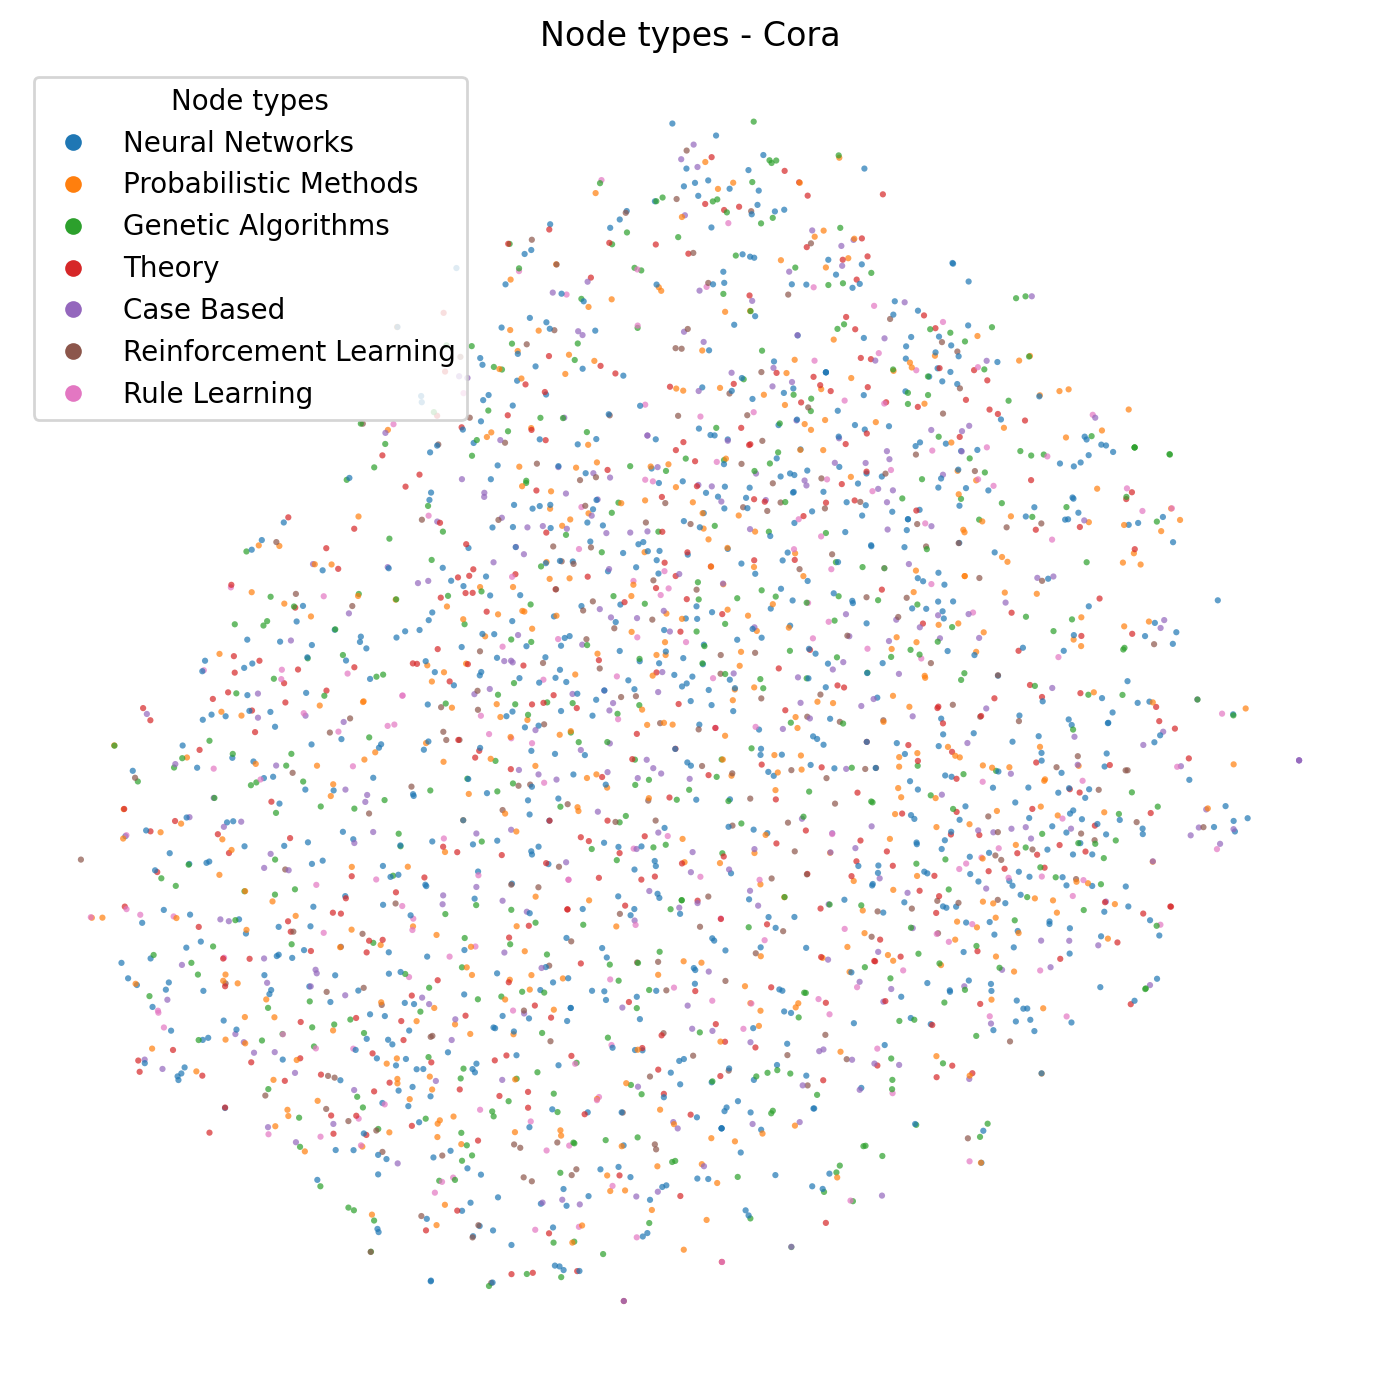

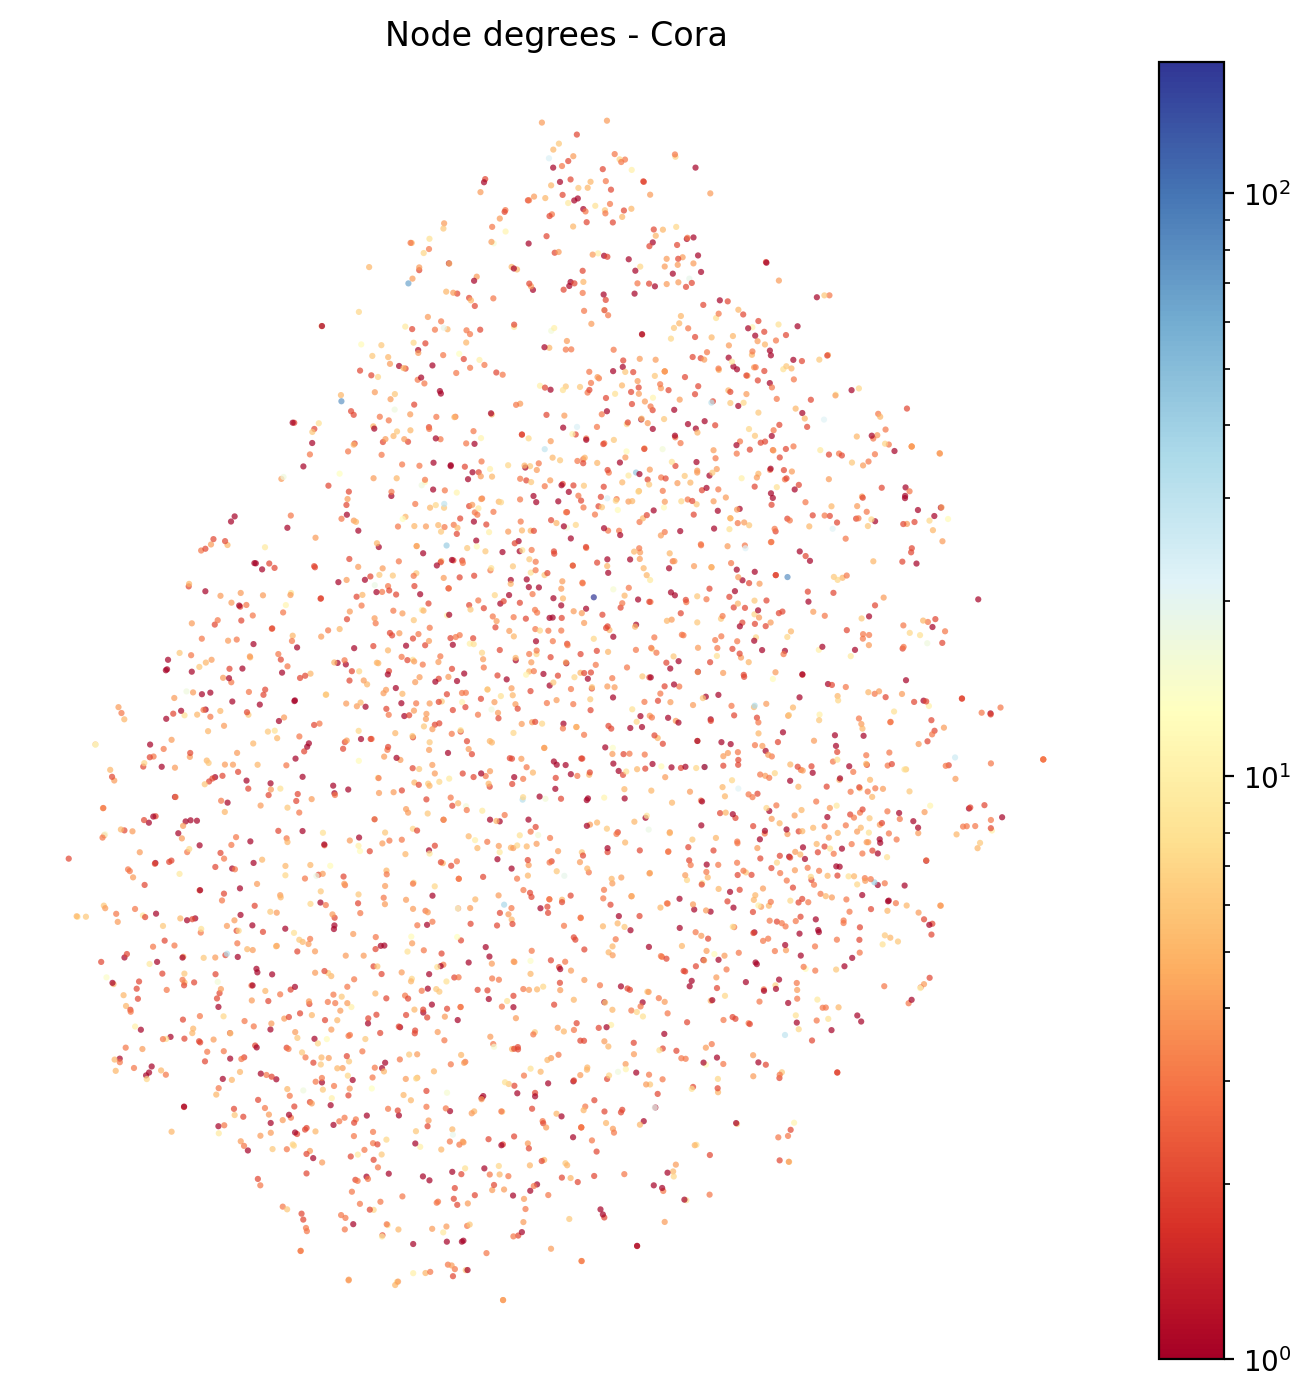

In [103]:
from embiggen import GraphVisualization
viz = GraphVisualization(cora)
viz.fit_transform_nodes(embedding)
viz.plot_node_types()
viz.plot_node_degrees()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.183s...
[t-SNE] Computed neighbors for 2708 samples in 1.689s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 7.429966
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.418602
[t-SNE] KL divergence after 1000 iterations: 0.894190


(<Figure size 1400x1400 with 2 Axes>,
 <AxesSubplot:title={'center':'Node degrees - Cora'}>)

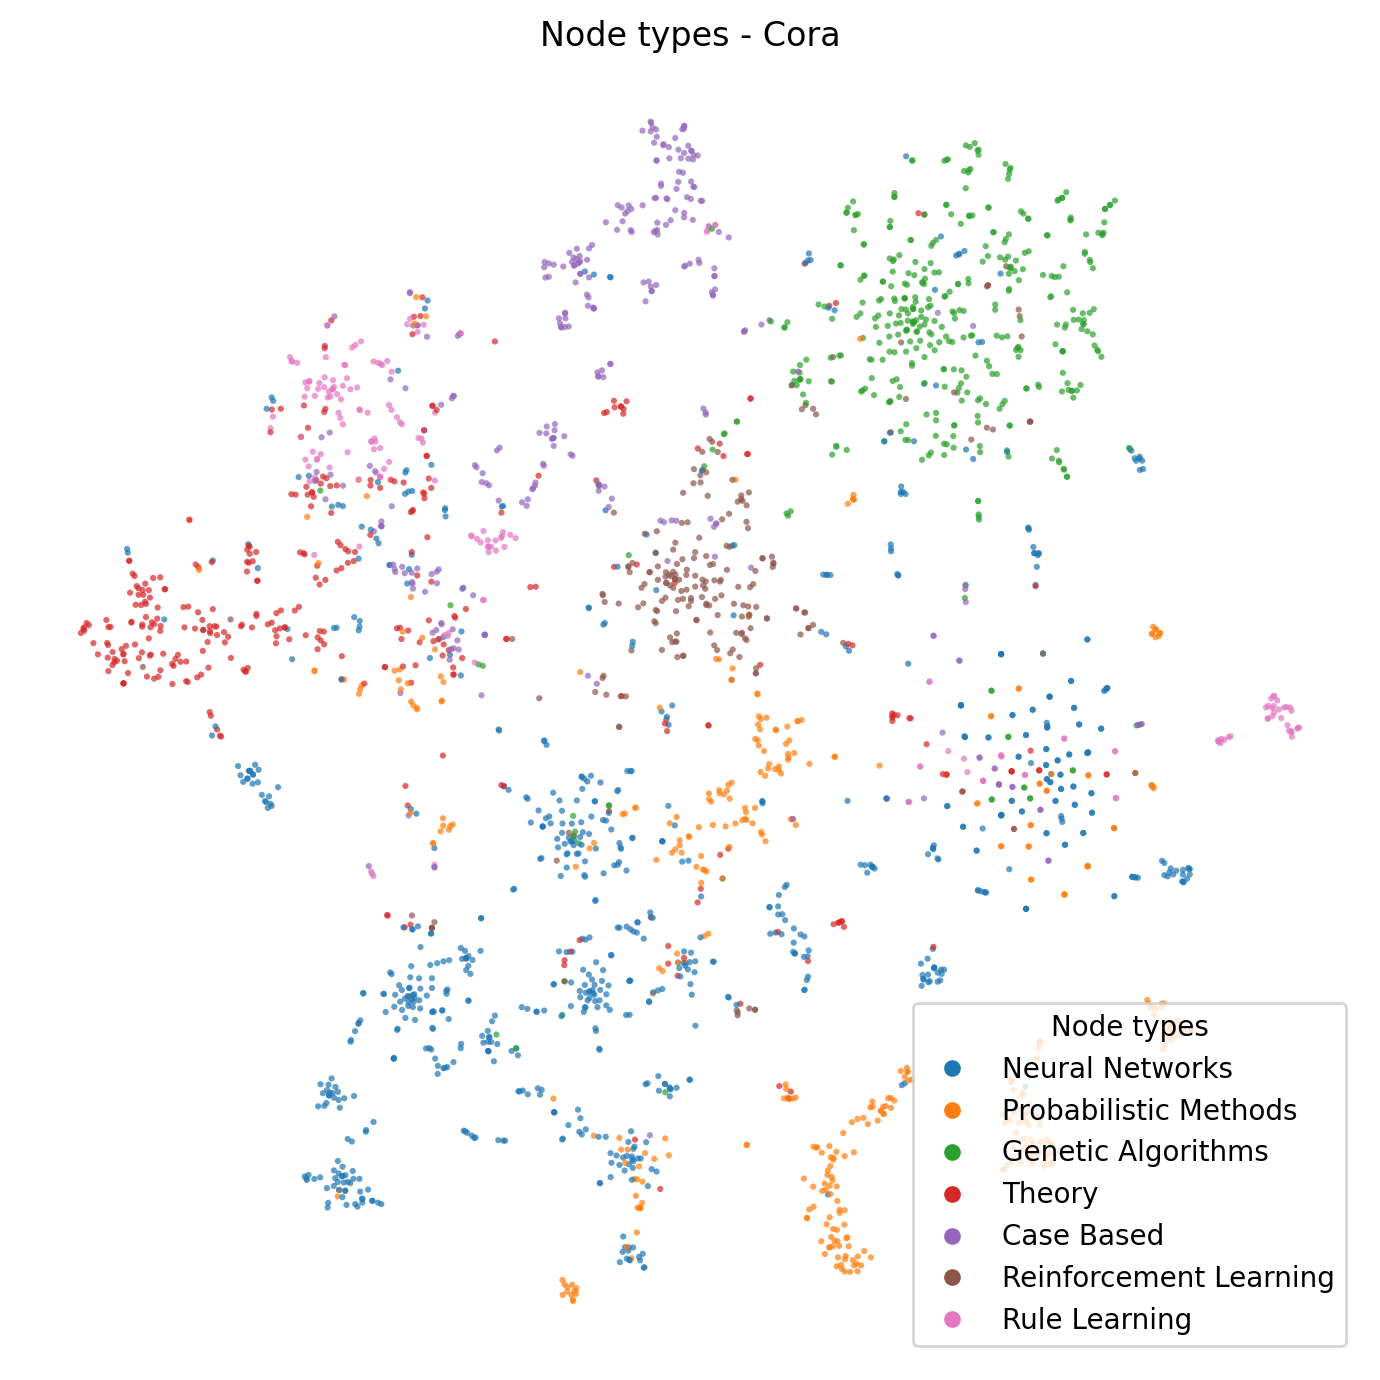

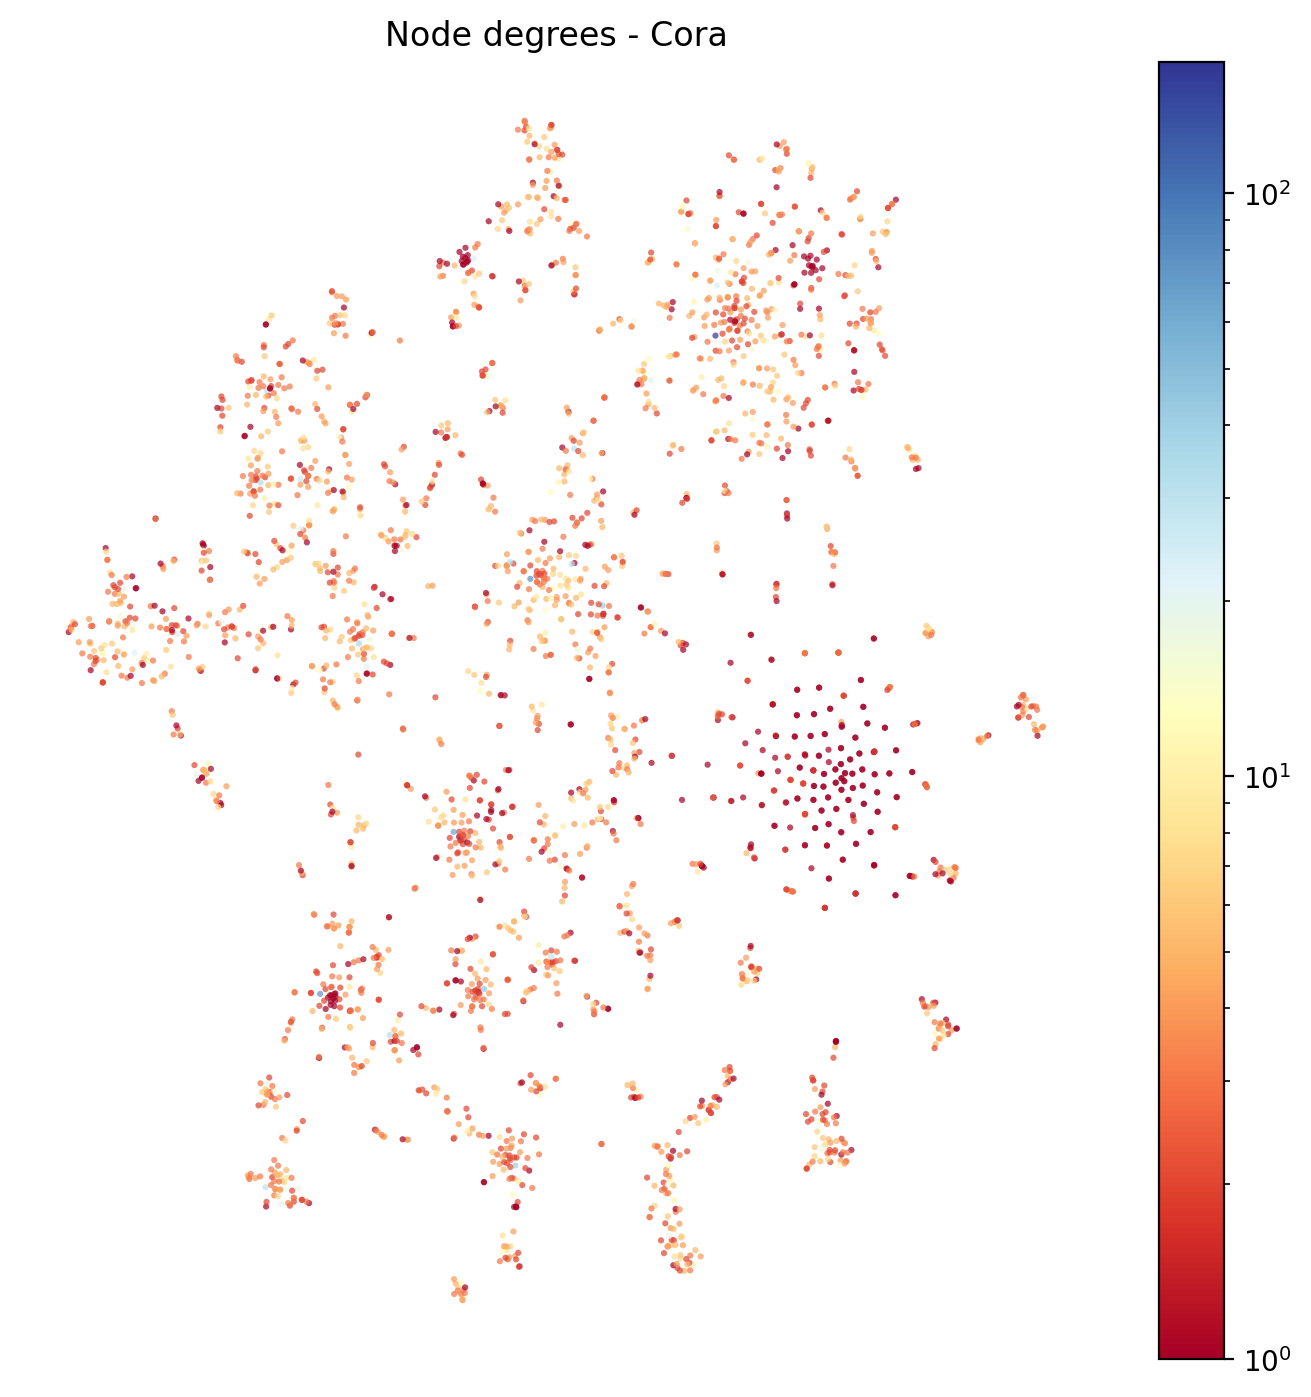

In [11]:
from embiggen import GraphVisualization
viz = GraphVisualization(cora)
viz.fit_transform_nodes(pd.DataFrame(cora.get_okapi_bm25_node_feature_propagation(features.values), index=cora.get_node_names()))
viz.plot_node_types()
viz.plot_node_degrees()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.001s...
[t-SNE] Computed neighbors for 2708 samples in 0.646s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.193958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.922020
[t-SNE] KL divergence after 1000 iterations: 2.513351


(<Figure size 1400x1400 with 2 Axes>,
 <AxesSubplot:title={'center':'Node degrees - Cora'}>)

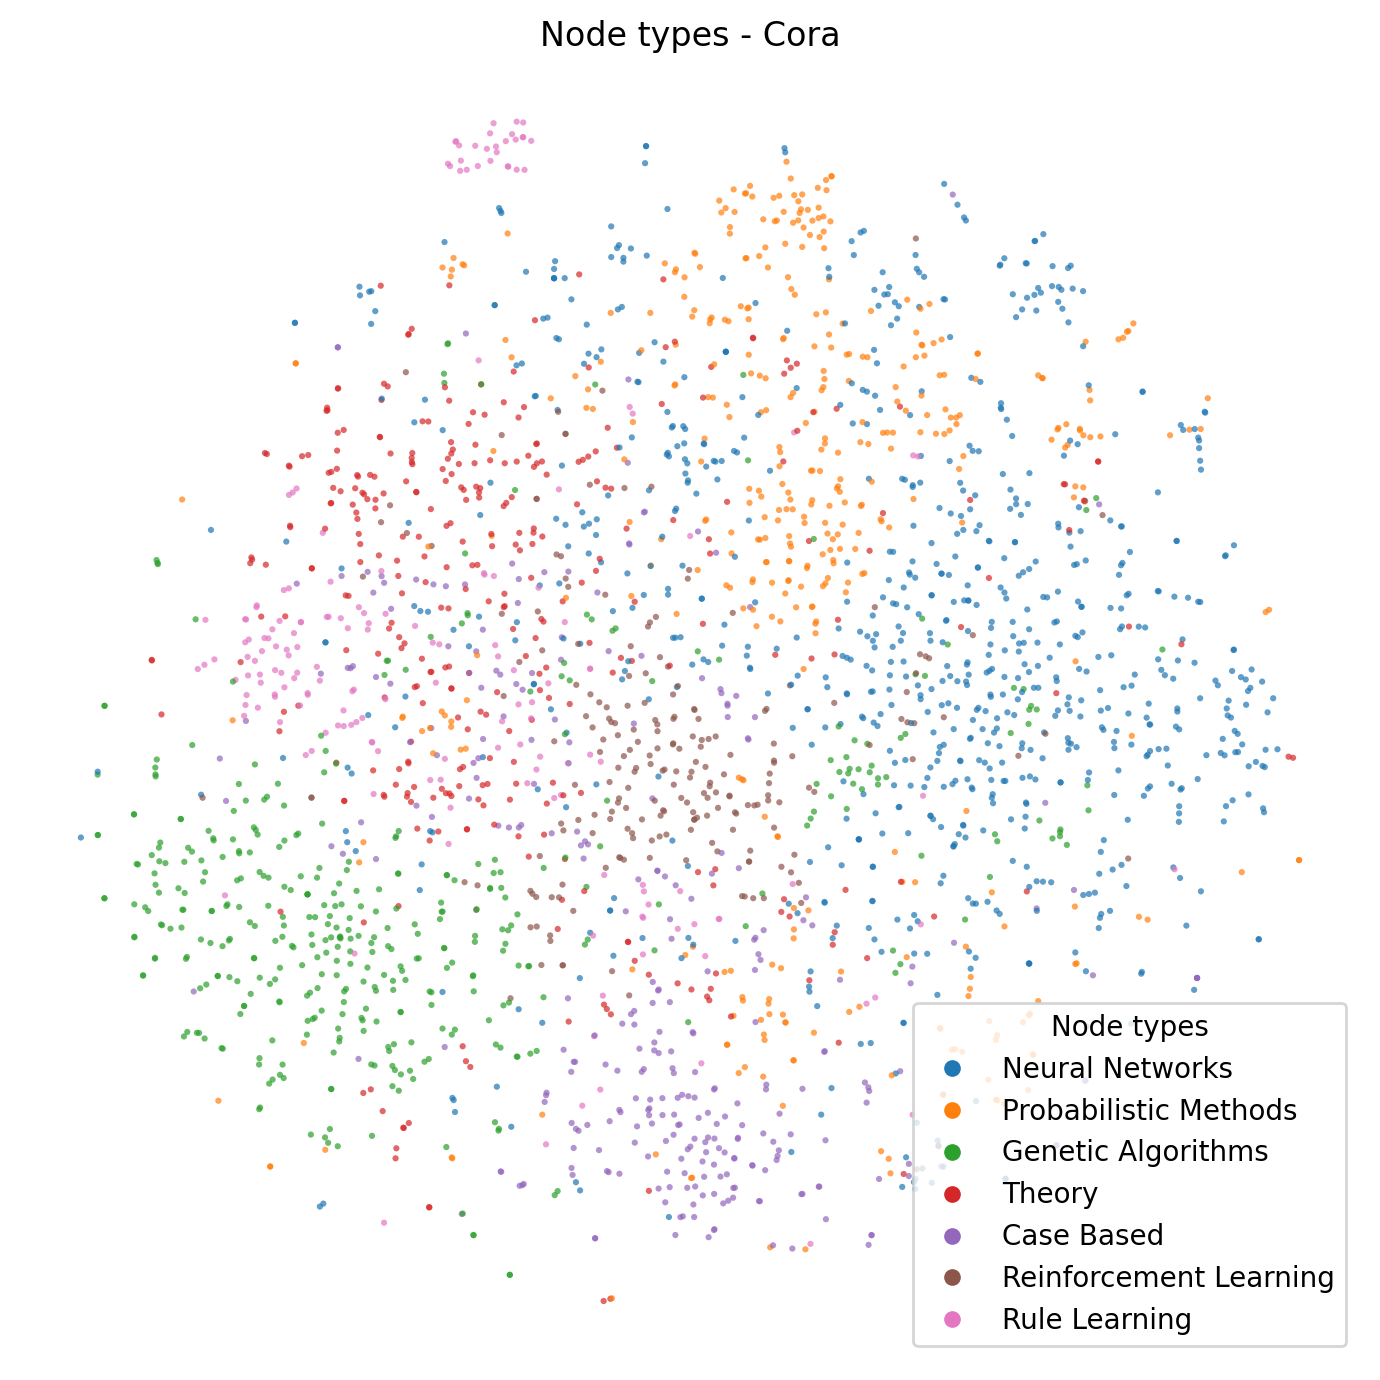

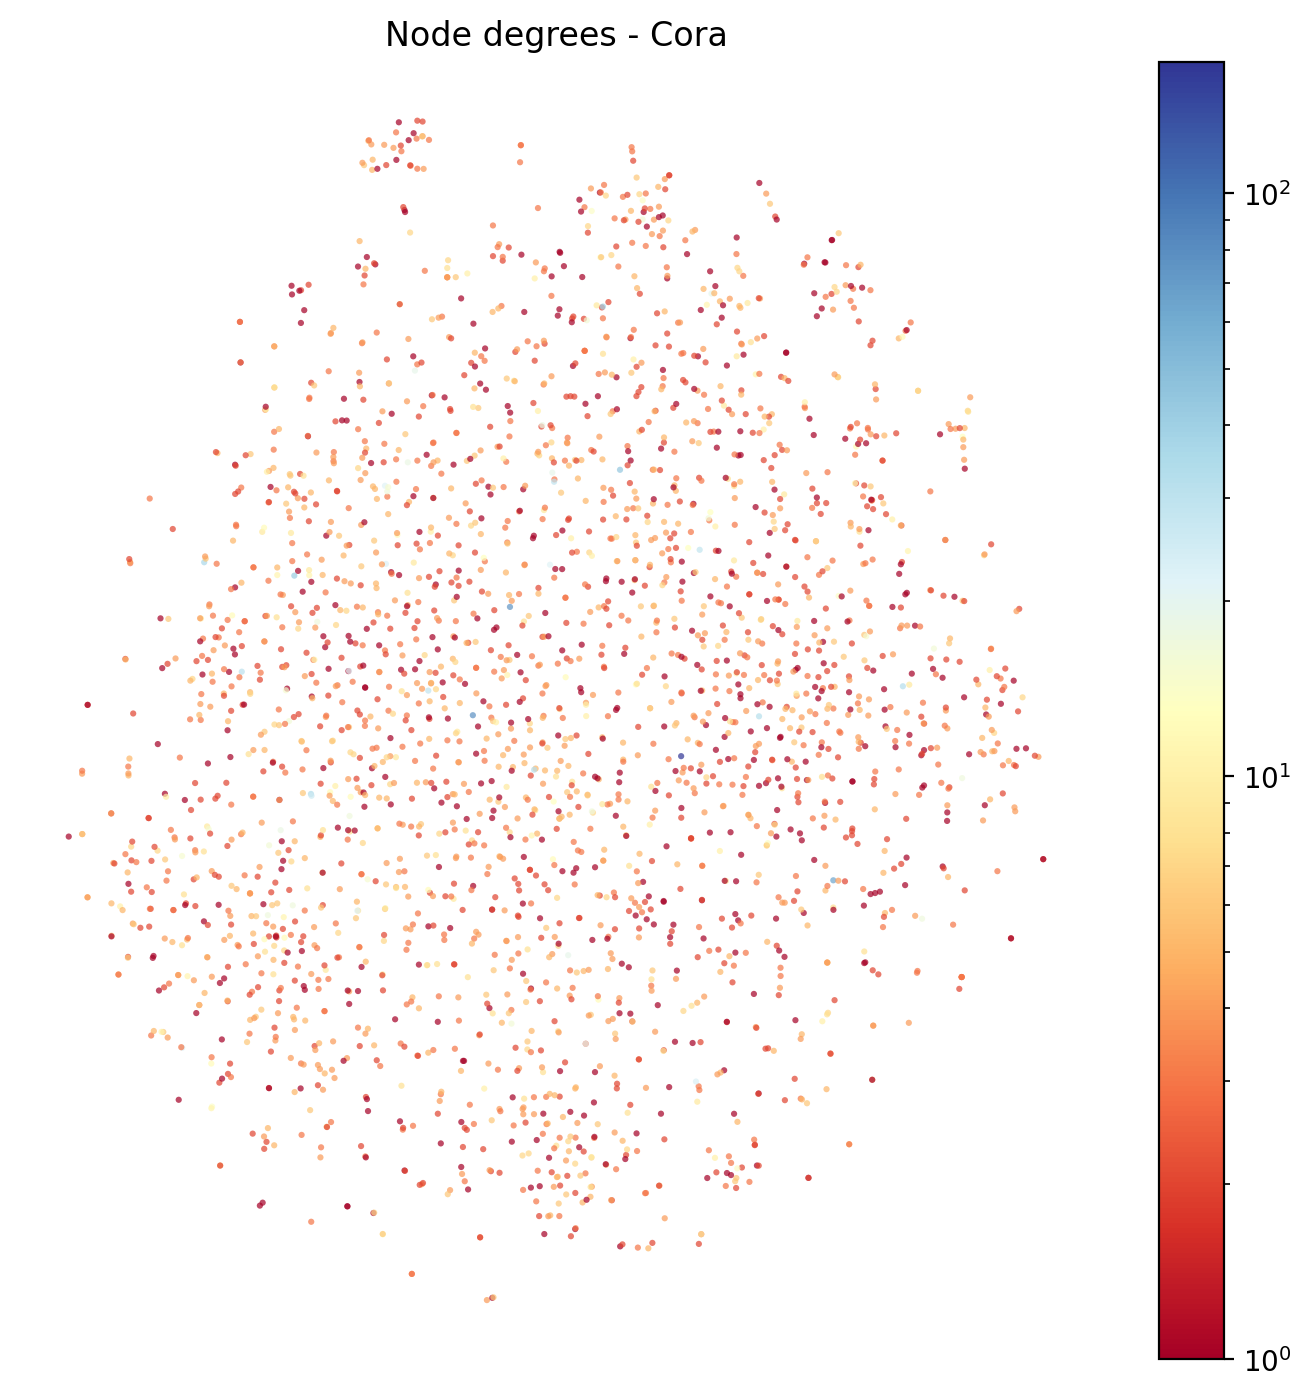

In [14]:
from embiggen import GraphVisualization
viz = GraphVisualization(cora, decomposition_kwargs={"metric":"cosine"})
viz.fit_transform_nodes(features)
viz.plot_node_types()
viz.plot_node_degrees()

In [105]:
cora.get_unweighted_symmetric_normalized_transformed_graph()

The undirected graph Cora has 2708 nodes and 5278 weighted edges, of which none are self-loops. The graph is sparse as it has a density of 0.00144 and has 78 connected components, where the component with most nodes has 2485 nodes and the component with the least nodes has 2 nodes. The graph median node degree is 3, the mean node degree is 3.90, and the node degree mode is 2. The top 5 most central nodes are 35 (degree 168), 6213 (degree 78), 1365 (degree 74), 3229 (degree 65) and 910 (degree 44). The hash of the graph is dd1e278fb33fda65.